In [78]:
import numpy as np
import gym
import matplotlib.pyplot as plt

class EpsilonGreedyQPolicy():
    
    def __init__(self, epsilon = 0.1):
        self.epsilon = epsilon

    def selectAction(self, qValues):
        nb_actions = qValues.shape[0]

        if np.random.uniform() < self.epsilon:
            action = np.random.randint(0, nb_actions)
        else:
            action = np.argmax(qValues)
        
        return action

class SARSALambaAgent():

    # def __init__(self, env, nb_actions, nb_states, gamma = 0.5, lambdaValue = 0, policy = EpsilonGreedyQPolicy(), terminalStates = None):
    def __init__(self, env, learningRate = 0.5, gamma = 1.0, lambdaValue = 0.0, policy = EpsilonGreedyQPolicy(), terminalStates = None):
        self.env = env
        # self.nb_actions = nb_actions
        self.nb_actions = None
        # self.nb_states = nb_states
        self.nb_states = None
        self.learningRate = learningRate
        self.gamma = gamma
        self.lambdaValue = lambdaValue
        self.policy = policy
        self.testPolicy = EpsilonGreedyQPolicy(0.0)
        # self.epsilon = self.policy.epsilon
        self.terminalStates = terminalStates
        self.currentState = None
        # self.currentState = self.env.reset()
        self.currentAction = None
        self.qValues = None
        self.eligibilityTrace = None
        self.qValuesHistory = None


        if isinstance(self.env.action_space, gym.spaces.discrete.Discrete):
            self.nb_actions = self.env.action_space.n

        if isinstance(self.env.observation_space, gym.spaces.discrete.Discrete):
            self.nb_states = self.env.observation_space.n

        # self.qValues = np.random.rand(self.nb_states, self.nb_actions)
        # self.eligibilityTrace = np.zeros_like(self.qValues)

        # if self.terminalStates is not None:
            # for state in self.terminalStates:
                # self.qValues[state] = np.zeros(self.nb_actions)

    def reset(self):
        self.qValues = np.random.rand(self.nb_states, self.nb_actions)
        self.eligibilityTrace = None

        if self.terminalStates is not None:
            for state in self.terminalStates:
                self.qValues[state] = np.zeros(self.nb_actions)
                # print(self.qValues[state])

        # self.eligibilityTrace = np.zeros_like(self.qValues)
        self.qValuesHistory = np.copy(self.qValues)[np.newaxis]

        # self.currentState = self.env.reset()
        self.currentState = None
        self.currentAction = None

    def resetEpisode(self):
        self.currentState = self.env.reset()
        self.currentAction = self.policy.selectAction(self.qValues[self.currentState])
        self.eligibilityTrace = np.zeros_like(self.qValues)
        # print(self.eligibilityTrace.shape)

    def estimateQValues(self, nb_episodes):
        self.reset()

        for episode in np.arange(nb_episodes):
            self.resetEpisode()
            # print(self.currentState)
            done = False
            reward = 0.0
            while done is not True:
                nextState, reward, done, info = self.env.step(self.currentAction)
                nextAction = self.policy.selectAction(self.qValues[nextState])
                error = reward + self.gamma * self.qValues[nextState][nextAction] - self.qValues[self.currentState][self.currentAction]
                self.eligibilityTrace[self.currentState][self.currentAction] += 1
                self.qValues += self.learningRate * error * self.eligibilityTrace
                self.eligibilityTrace[:] = self.gamma * self.lambdaValue * self.eligibilityTrace[self.currentState][self.currentAction]
                self.currentState = nextState
                self.currentAction = nextAction
            self.qValuesHistory = np.concatenate([self.qValuesHistory, np.copy(self.qValues)[np.newaxis]], axis = 0)

    def evaluateQValues(self):
        self.resetEpisode()
        done = False
        reward = 0.0
        tReward = 0.0
        while done is not True:
            nextState, reward, done, info = self.env.step(self.currentAction)
            nextAction = self.testPolicy.selectAction(self.qValues[nextState])
            self.currentState = nextState
            self.currentAction = nextAction
            tReward += reward
        print(tReward)

    def getQValuesHistory(self):
        if self.qValuesHistory is not None:
            return np.copy(self.qValuesHistory)
        else:
            return None

In [79]:
ENV_NAME = 'CliffWalking-v0'
env = gym.make(ENV_NAME)
nb_actions = env.action_space.n
nb_states = env.observation_space.n

sarsaLambdaAgentOne = SARSALambaAgent(env, 0.5, 1.0, 0.0, EpsilonGreedyQPolicy(0.1), np.array([47]))
sarsaLambdaAgentTwo = SARSALambaAgent(env, 0.5, 1.0, 0.3, EpsilonGreedyQPolicy(0.1), np.array([47]))
sarsaLambdaAgentThree = SARSALambaAgent(env, 0.5, 1.0, 0.5, EpsilonGreedyQPolicy(0.1), np.array([47]))
sarsaLambdaAgentFour = SARSALambaAgent(env, 0.5, 1.0, 0.7, EpsilonGreedyQPolicy(0.1), np.array([47]))
sarsaLambdaAgentFive = SARSALambaAgent(env, 0.5, 1.0, 0.9, EpsilonGreedyQPolicy(0.1), np.array([47]))
# sarsaLambdaAgent.reset()
# print(sarsaLambdaAgent.getQValuesHistory().shape)
sarsaLambdaAgentOne.estimateQValues(500)
sarsaLambdaAgentTwo.estimateQValues(500)
sarsaLambdaAgentThree.estimateQValues(500)
sarsaLambdaAgentFour.estimateQValues(500)
sarsaLambdaAgentFive.estimateQValues(500)
# sarsaLambdaAgent.evaluateQValues()
qValueHistoryOne = np.amax(sarsaLambdaAgentOne.getQValuesHistory(), axis = 2)
qValueHistoryTwo = np.amax(sarsaLambdaAgentTwo.getQValuesHistory(), axis = 2)
qValueHistoryThree = np.amax(sarsaLambdaAgentThree.getQValuesHistory(), axis = 2)
qValueHistoryFour = np.amax(sarsaLambdaAgentFour.getQValuesHistory(), axis = 2)
qValueHistoryFive = np.amax(sarsaLambdaAgentFive.getQValuesHistory(), axis = 2)
# print(hist.shape)
# print(np.amax(hist, axis = 2))
# treaOne = np.amax(hist, axis = 2)
# print(hist[0][36])
# print(hist[10][36])
# print(hist[499])
print(qValueHistoryOne[500])
print(qValueHistoryTwo[1])


[-16.30702586 -14.86848297 -13.38507806 -12.11862457 -11.03915641
 -10.59026344 -11.03912298  -9.34986356  -6.79968506  -5.12336784
  -4.04264706  -3.00884306 -17.59002454 -15.71111387 -18.24517961
 -14.76096959 -14.23672087 -12.01776221 -10.53994373 -11.58132941
 -11.49957101  -9.82718457  -3.02137963  -2.00083249 -19.08832918
 -17.32797803 -18.51456328  -9.00487999 -13.87062698 -12.41377856
 -11.5539584  -11.79044214 -11.44378191 -11.4599207   -2.
  -1.         -21.20034103   0.62872962   0.79660032   0.90797459
   0.8169791    0.97390623   0.63295783   0.98116616   0.97046085
   0.912755     0.53792079   0.        ]
[-357.99271212 -357.26832163 -357.17364339 -357.05750465 -356.76266296
 -356.7106791  -356.20397387 -356.00343438 -355.67059588 -356.05175679
 -356.04073829 -355.72473394 -358.00794719 -357.42311105 -357.92875044
 -357.45607355 -357.1257628  -356.8668171  -356.26074669 -355.82324241
 -355.48044132 -355.6533844  -355.63134578 -355.55933709 -358.42127036
 -357.93662885 -35

In [80]:
# print(type(env.observation_space))
# temp = np.array([2]) 
# print(temp.shape)
# for i in temp:
    # print(i)

# mO = np.ones((48, 4))
# mO[:] = 3
# print(mO.shape)
# mT = np.ones((48, 4))
# print(mO)
# print(mO.shape)
# mF = mT + mO
# print(mF)
# print(mF.shape)
# print(np.concatenate([mO[np.newaxis], mT[np.newaxis]], axis = 0).shape)
# print(np.concatenate([mO[np.newaxis], mT[np.newaxis]], axis = 0))
# print(np.copy(mT)[np.newaxis].shape)
# print(np.copy(mT)[np.newaxis])
# print(np.append(mO, np.append(mO, mT, axis = 2), axis = 2).shape)

0.9973373987738136
-21874.59412501268
0.993001451963154
-32.67964835525554
0.9933324401873992
-1419.579489815686
0.9898273165263192
-4180.219085824636
0.9973373987738136
-10399.191276622318
0.9795217471048792
-21874.59412501268
0.993001451963154
-32.67964835525554
0.9933324401873992
-1419.579489815686
0.9898273165263192
-4180.219085824636
0.9973373987738136
-10399.191276622318
0.9795217471048792
-21874.59412501268
0.993001451963154
-32.67964835525554
0.9933324401873992
-1419.579489815686
0.9898273165263192
-4180.219085824636
0.9973373987738136
-10399.191276622318
0.9795217471048792
-21874.59412501268
0.993001451963154
-32.67964835525554
0.9933324401873992
-1419.579489815686
0.9898273165263192
-4180.219085824636
0.9973373987738136
-10399.191276622318
0.9795217471048792
-21874.59412501268
0.993001451963154
-32.67964835525554
0.9933324401873992
-1419.579489815686
0.9898273165263192
-4180.219085824636
0.9973373987738136
-10399.191276622318
0.9795217471048792
-21874.59412501268
0.9930014519

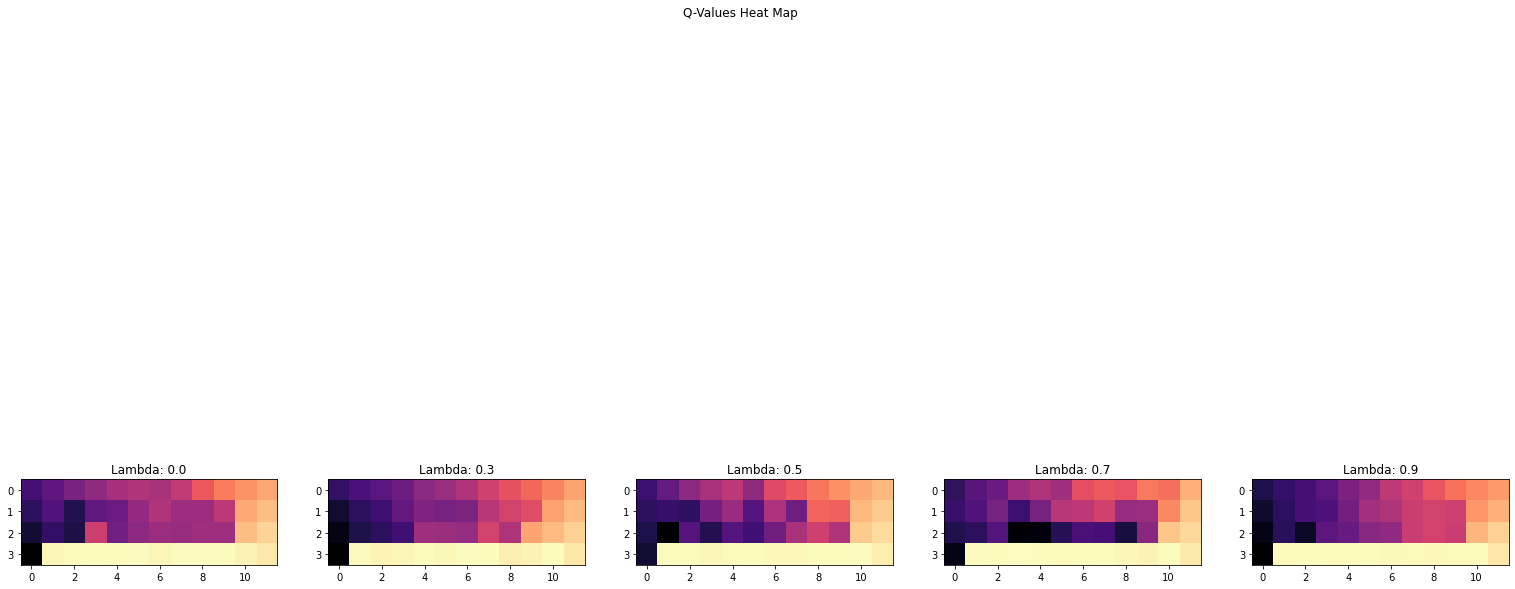

In [81]:
# Agents' trajectories|path taken represented using a heat map plot.
my_dpi = 72
trajectoryFig = plt.figure(figsize=(1920/my_dpi, 1080/my_dpi), dpi=my_dpi, frameon = True)
# trajectoryFig = plt.figure(figsize=(37.5, 7.5), frameon = True)
# trajectoryFig = plt.figure(figsize=(20.0, 5.0), frameon = True)
trajectoryGrid = trajectoryFig.add_gridspec(1, 5)
trajectoryPlot = trajectoryGrid.subplots()
# np.amax(np.abs(np.array([qValueHistoryOne, qValueHistoryTwo, qValueHistoryThree, qValueHistoryFour, qValueHistoryFive])))

largestValue = np.amax(np.array([qValueHistoryOne, qValueHistoryTwo, qValueHistoryThree, qValueHistoryFour, qValueHistoryFive]))
smallestValue = np.amin(np.array([qValueHistoryOne, qValueHistoryTwo, qValueHistoryThree, qValueHistoryFour, qValueHistoryFive]))
print(largestValue)
print(smallestValue)
for i in np.arange(len(qValueHistoryOne)):
# for i in np.arange(1):
    trajectoryFig.suptitle("Q-Values Heat Map")
    trajectoryPlot[0].set_title("Lambda: 0.0")
    largestValueOne = np.amax(qValueHistoryOne)
    smallestValueOne = np.amin(qValueHistoryOne)
    print(largestValueOne)
    print(smallestValueOne)
    # trajectoryPlot[0].imshow(qValueHistoryOne[500].reshape(4, 12), vmin = smallestValue, vmax = largestValue, alpha=0.8, cmap='magma')
    # trajectoryPlot[0].imshow(qValueHistoryOne[500].reshape(4, 12), vmin = smallestValueOne, vmax = largestValueOne, alpha=0.8, cmap='magma')
    trajectoryPlot[0].imshow(qValueHistoryOne[i].reshape(4, 12), alpha=0.8, cmap='magma')
    trajectoryPlot[1].set_title("Lambda: 0.3")
    largestValueTwo = np.amax(qValueHistoryTwo)
    smallestValueTwo = np.amin(qValueHistoryTwo)
    print(largestValueTwo)
    print(smallestValueTwo)
    # trajectoryPlot[1].imshow(qValueHistoryTwo[500].reshape(4, 12), vmin = smallestValue, vmax = largestValue, alpha=0.8, cmap='magma')
    # trajectoryPlot[1].imshow(qValueHistoryTwo[500].reshape(4, 12), vmin = smallestValueTwo, vmax = largestValueTwo, alpha=0.8, cmap='magma')
    trajectoryPlot[1].imshow(qValueHistoryTwo[i].reshape(4, 12), alpha=0.8, cmap='magma')
    trajectoryPlot[2].set_title("Lambda: 0.5")
    largestValueThree = np.amax(qValueHistoryThree)
    smallestValueThree = np.amin(qValueHistoryThree)
    print(largestValueThree)
    print(smallestValueThree)
    # trajectoryPlot[2].imshow(qValueHistoryThree[500].reshape(4, 12), vmin = smallestValue, vmax = largestValue, alpha=0.8, cmap='magma')
    # trajectoryPlot[2].imshow(qValueHistoryThree[500].reshape(4, 12), vmin = smallestValueThree, vmax = largestValueThree, alpha=0.8, cmap='magma')
    trajectoryPlot[2].imshow(qValueHistoryThree[i].reshape(4, 12), alpha=0.8, cmap='magma')
    trajectoryPlot[3].set_title("Lambda: 0.7")
    largestValueFour = np.amax(qValueHistoryFour)
    smallestValueFour = np.amin(qValueHistoryFour)
    print(largestValueFour)
    print(smallestValueFour)
    # trajectoryPlot[3].imshow(qValueHistoryFour[500].reshape(4, 12), vmin = smallestValue, vmax = largestValue, alpha=0.8, cmap='magma')
    # trajectoryPlot[3].imshow(qValueHistoryFour[500].reshape(4, 12), vmin = smallestValueFour, vmax = largestValueFour, alpha=0.8, cmap='magma')
    trajectoryPlot[3].imshow(qValueHistoryFour[i].reshape(4, 12), alpha=0.8, cmap='magma')
    trajectoryPlot[4].set_title("Lambda: 0.9")
    largestValueFive = np.amax(qValueHistoryFive)
    smallestValueFive = np.amin(qValueHistoryFive)
    print(largestValueFive)
    print(smallestValueFive)
    # trajectoryPlot[4].imshow(qValueHistoryFive[500].reshape(4, 12), vmin = smallestValue, vmax = largestValue, alpha=0.8, cmap='magma')
    # trajectoryPlot[4].imshow(qValueHistoryFive[500].reshape(4, 12), vmin = smallestValueFive, vmax = largestValueFive, alpha=0.8, cmap='magma')
    trajectoryPlot[4].imshow(qValueHistoryFive[i].reshape(4, 12), alpha=0.8, cmap='magma')

    # plt.show()
    plt.savefig(str(i) + '.png', facecolor = 'white', transparent = False)